In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize, integrate, stats
import time

In [2]:
## Self explanatory
save_plots = False
save_results = False

In [3]:
#n_experiments = 10000
n_experiments = 10
fit_bins = 20
events_per_experiment = 5000#20000

In [4]:
## 'perfect': no smearing at all
## 'nocross' smearing matching resolution after removing ghost vertices
## 'current': smearing matching resolution of the current dataset, ghost vertices included
dataset_to_produce = 'nocross'

In [5]:
if dataset_to_produce == 'perfect':
    add_smearing = False
elif dataset_to_produce == 'nocross':
    add_smearing = True
    ctheta_smearing = 0.097
    phi_smearing = 0.332
elif dataset_to_produce == 'current':
    add_smearing = True
    ctheta_smearing = 0.253
    phi_smearing = 1.083
else:
    raise ValueError

# A look at the PDF

In [6]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [7]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [8]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [9]:
def pdf(cos_theta, phi, sz=1, g=1.226, Dy=4, beta=1.):
    alpha = 0.732
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(np.arccos(cos_theta)) * np.cos(phi),
        np.sin(np.arccos(cos_theta)) * np.sin(phi),
        cos_theta
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [10]:
theta_min = -1
theta_max = 1

phi_min = -np.pi
phi_max = np.pi

bins = 100

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = pdf(theta_grid, phi_grid)

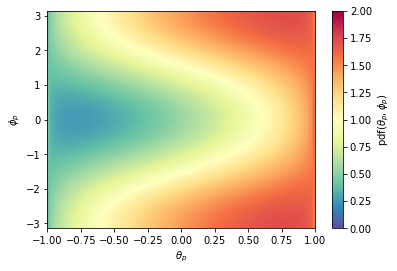

In [11]:
plt.imshow(ys,extent=[theta_min, theta_max, phi_min, phi_max], cmap='Spectral_r', origin='lower', aspect='auto')
#plt.imshow(ys, cmap='Spectral_r', origin='lower')

plt.clim(0,2)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

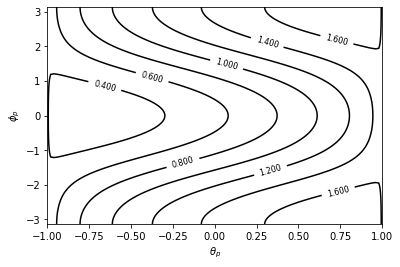

In [12]:
contours = plt.contour(theta_grid, phi_grid, ys, colors='k')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

# Event generation

In [13]:
class Generator:
    
    def __init__(self,
        event_number: int, 
        random_state: int = 2022,
        ctheta_resolution = None,
        phi_resolution = None,
        g: float = 1.226
    ):
        self._event_number = event_number
        self._random_state = random_state
        random.seed(random_state)
        
        self._ctheta_resolution = ctheta_resolution
        self._phi_resolution = phi_resolution
        
        if ctheta_resolution is not None:
            self._add_smearing_ctheta = True
        else:
            self._add_smearing_ctheta = False
        
        if phi_resolution is not None:
            self._add_smearing_phi = True
        else:
            self._add_smearing_phi = False
            
        self._g = g
    
    ## Getter and setter methods
    ### Event number
    @property
    def event_number(self) -> int:
        return self._event_number
    
    @event_number.setter
    def event_number(self, n) -> None:
        self._event_number = n
    
    ### Random state
    @property
    def random_state(self) -> int:
        return self._random_state
    
    @random_state.setter
    def random_state(self, n) -> None:
        self._random_state = n
        random.seed(n)
    
    ### Theta resolution
    @property
    def ctheta_resolution(self) -> float:
        return self._ctheta_resolution
    
    ### Phi resolution
    @property
    def phi_resolution(self) -> float:
        return self._phi_resolution
    
    ### Smear the angles?
    @property
    def add_smearing_ctheta(self) -> bool:
        return self._add_smearing_ctheta
    
    @property
    def add_smearing_phi(self) -> bool:
        return self._add_smearing_phi
    
    ### g for generation
    @property
    def g(self) -> float:
        return self._g
    
    ## Method to smear theta and phi with a gaussian of resolution sigma
    def smear_angle(self, angle: float, sigma: float):
        return random.gauss(angle, sigma)
    
    ## Method to smear cos(theta). This one only smears up to the -1, +1 edges.
    ## If the smearing would go past it, then it retries
    ## Note: it's not necessarily the right way to do this. The alternative
    ## is to fix the smear at -1 if the smeared angle would go past it.
    ## It would be a good idea to think critically at how the measurement is made
    ## and choose the technique to match possible resolution issues in real data.
    def smear_ctheta(self, theta: float, sigma: float):
        left_bound = -1
        right_bound = +1
        
        while True:
            reco_ctheta = self.smear_angle(theta, sigma)
            if left_bound <= reco_ctheta <= right_bound:
                break
        
        return reco_ctheta
    
    ## Method to smear phi. Here the smearing "wraps around" since -pi and pi are
    ## physically the same angle.
    def smear_phi(self, phi: float, sigma: float):
        reco_phi = self.smear_angle(phi, sigma)
        left_bound = -np.pi
        right_bound = np.pi
        
        if left_bound <= reco_phi <= right_bound:
            return reco_phi
        elif reco_phi < left_bound:
            return right_bound - (left_bound - reco_phi)
        elif reco_phi > right_bound:
            return left_bound + (reco_phi - right_bound)
        else:
            raise ValueError
        
    ## Individual generators
    def generate_omega(self) -> Tuple[float]:
        pdf_min = 0
        pdf_max = 2
                
        while True:
            ctheta = random.uniform(-1, 1)
            phi = random.uniform(-np.pi,np.pi)
            yref = random.uniform(pdf_min, pdf_max)
            
            if yref <= pdf(ctheta, phi, g=self._g):
                break
                
        if self._add_smearing_ctheta:
            ctheta = self.smear_ctheta(ctheta, self._ctheta_resolution)
        
        if self._add_smearing_phi:
            phi = self.smear_phi(phi, self._phi_resolution)
        
        return ctheta, phi
    
    ## For now it's very simplified: lambda momentum along z, maximal polarization s0 = 1, g=1.226, Dy = 4 T m, beta= 1
    def generate_event(self) -> dict:
        #own_vertex = [0,0, random.uniform(0,1000)]
        #momentum = [0,0,random.uniform(0,10000)]
        #decay_length = random.uniform(0,5000)
        
        #end_vertex = [
        #    random.uniform(-1000,1000),
        #    random.uniform(-1000,1000),
        #    random.uniform(5500,8500)
        #]
        
        ctheta, phi = self.generate_omega()
        
        event_dict = {
            #'L_OWNVERTEX_X': own_vertex[0],
            #'L_OWNVERTEX_Y': own_vertex[1],
            #'L_OWNVERTEX_Z': own_vertex[2],
            #'L_PX': momentum[0],
            #'L_PY': momentum[1],
            #'L_PZ': momentum[2],
            #'L_DECAYLENGTH': decay_length,
            #'L_ENDVERTEX_X': end_vertex[0],
            #'L_ENDVERTEX_Y': end_vertex[1],
            #'L_ENDVERTEX_Z': end_vertex[2],
            'COSTHETA': ctheta,
            'PHI': phi
        }
        
        return event_dict
    
    def generate_sample(self) -> pd.DataFrame:
        events = []
        
        for i in range(self._event_number):
            events.append(self.generate_event())
        
        df = pd.DataFrame(events)
        
        return df

In [14]:
if add_smearing:
    pseudo_experiment_generator = Generator(event_number=events_per_experiment, random_state=2021, ctheta_resolution=ctheta_smearing, phi_resolution=phi_smearing)
else:
    pseudo_experiment_generator = Generator(event_number=events_per_experiment, random_state=2021)
df_generated = pseudo_experiment_generator.generate_sample()
df_generated

,COSTHETA,PHI
0,0.674983,2.722587
1,0.933500,0.209279
2,0.658920,1.287674
3,-0.104705,-2.471990
4,-0.630794,-2.441636
...,...,...
4995,0.693245,-2.896096
4996,0.114049,-0.777695
4997,0.298713,-1.322466
4998,0.529641,3.042074


# Analysis of generated events

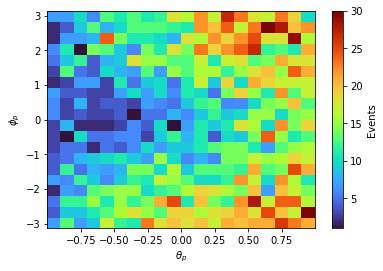

In [15]:
plt.hist2d(df_generated['COSTHETA'], df_generated['PHI'], cmap='turbo', bins=20)
plt.colorbar(label='Events')
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

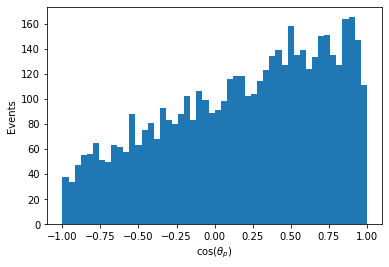

In [16]:
plt.hist(df_generated['COSTHETA'],bins=50)
plt.xlabel(r"$\cos(\theta_p)$")
plt.ylabel("Events")
plt.show()

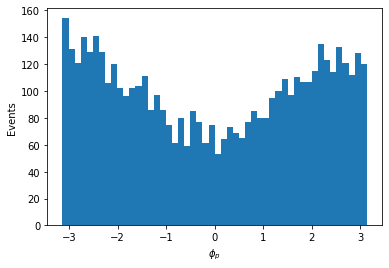

In [17]:
plt.hist(df_generated['PHI'],bins=50)
plt.xlabel(r"$\phi_p$")
plt.ylabel("Events")
plt.show()

# Fit of events

In [18]:
def pdf_theta(ctheta: float, g: float):
    alpha = 0.732
    Dy = 4.
    beta = 1.
    sz0 = 1.
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    sz = sz0 * np.cos(Phi_rot)
    
    return 2. * np.pi * (1. + alpha * sz * ctheta)

def pdf_phi(phi: float, g: float):
    alpha = 0.732
    Dy = 4.
    beta = 1.
    sz0 = 1.
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    sx = - sz0 * np.sin(Phi_rot)
    
    return 2. + alpha * np.pi * sx * np.cos(phi) / 2.

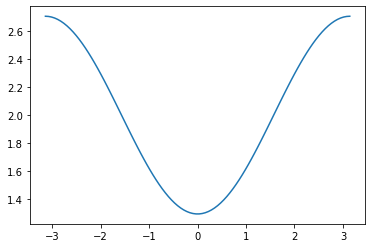

In [36]:
plt.plot(np.linspace(-np.pi, np.pi, 100), pdf_phi(np.linspace(-np.pi, np.pi, 100), 1.226))
plt.show()

In [19]:
epsabs = 1e-3

In [20]:
def pdf_theta_convoluted(ctheta: float, g: float):
    y, _ = integrate.quad(lambda t: pdf_theta(t, g=g) * stats.norm.pdf(ctheta - t, 0, ctheta_smearing), -1 ,1, epsabs=epsabs)
    return y

def pdf_theta_convoluted_vect(ctheta: float, g: float):
    return np.vectorize(pdf_theta_convoluted)(ctheta, g)

In [21]:
def pdf_phi_convoluted(phi: float, g: float):
    y, _ = integrate.quad(lambda t: pdf_phi(t, g=g) * stats.norm.pdf(phi - t, 0, phi_smearing), -np.pi, np.pi, epsabs=epsabs)
    return y

def pdf_phi_convoluted_vect(phi: float, g: float):
    return np.vectorize(pdf_phi_convoluted)(phi, g)

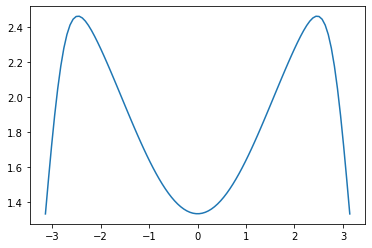

In [37]:
plt.plot(np.linspace(-np.pi, np.pi, 100), pdf_phi_convoluted_vect(np.linspace(-np.pi, np.pi, 100), 1.226))
plt.show()

In [22]:
def function_for_fit_theta(cthetas: np.array, S: float, g: float) -> float:
    return S * pdf_theta_convoluted_vect(cthetas, g=g)

def function_for_fit_phi(phis: np.array, S: float, g: float) -> float:
    return S * pdf_phi_convoluted_vect(phis, g=g)

In [23]:
fit_func = {
     'param_names' : [r'S',  r'g'],
     'p0'          : [100,   1.2],
     'lb'          : [1,     0.5],
     'ub'          : [100000, 2]
}

In [24]:
def pdg_round(value, error) :
    "Given a value and an error, round and format them according to the PDG rules for significant digits"
    def three_digits(value) :
        "extract the three most significant digits and return them as an int"
        return int(("%.2e"%float(error)).split('e')[0].replace('.','').replace('+','').replace('-',''))
    def n_significant_digits(three_digits) :
        assert three_digits<1000,"three digits (%d) cannot be larger than 10^3"%three_digits
        if three_digits<101 : return 2 # not sure
        elif three_digits<356 : return 2
        elif three_digits<950 : return 1
        else : return 2
    def frexp10(value) :
        "convert to mantissa+exp representation (same as frex, but in base 10)"
        valueStr = ("%e"%float(value)).split('e')
        return float(valueStr[0]), int(valueStr[1])
    def n_digits_value(expVal, expErr, nDigitsErr) :
        "compute the number of digits we want for the value, assuming we keep nDigitsErr for the error"
        return expVal-expErr+nDigitsErr
    def format_value(value, exponent, nDigits, extraRound=0) :
        "Format the value; extraRound is meant for the special case of three_digits>950"
        roundAt = nDigits-1-exponent - extraRound
        nDec = roundAt if exponent<nDigits else 0
        nDec = max([nDec, 0])
        return ('%.'+str(nDec)+'f')%round(value,roundAt)
    tD = three_digits(error)
    nD = n_significant_digits(tD)
    expVal, expErr = frexp10(value)[1], frexp10(error)[1]
    extraRound = 1 if tD>=950 else 0
    return (format_value(value, expVal, n_digits_value(expVal, expErr, nD), extraRound),
            format_value(error,expErr, nD, extraRound))

In [25]:
def fit(generator: Generator, variable: str, binning: int = 20) -> dict:
    df_gen = df_gen = generator.generate_sample()
    evt_number, edges, _ = plt.hist(df_gen[variable], bins=binning)
    plt.close()
    midpoints = (edges[:-1] + edges[1:])/2

    xdata = midpoints
    ydata = evt_number
    
    if variable == 'COSTHETA':
        func = function_for_fit_theta
    else:
        func = function_for_fit_phi

    param_best, param_covmatrix = optimize.curve_fit(
        f=func,
        xdata=xdata,
        ydata=ydata,
        p0=fit_func['p0'],
        sigma=np.sqrt(ydata),
        bounds=(
            fit_func['lb'],
            fit_func['ub']
        )
    )

    param_names = fit_func['param_names']
    param_error = np.sqrt(np.diag(param_covmatrix))

    fit_results_dictionary = {}

    for name, best, error in zip(param_names, param_best, param_error):
        fit_results_dictionary[name] = best
        fit_results_dictionary[f'{name}_ERR'] = error
        
    return fit_results_dictionary

In [26]:
tick = time.perf_counter()

In [27]:
fit_result_list = []
pseudoexperiments_run = 0
sigma_zero_counter = 0

while True:
    
    if pseudoexperiments_run % (n_experiments/10) == 0:
        print(f"Processing pseudoexperiment {pseudoexperiments_run}...")
        
    fit_result = {}
    
    for variable in ['COSTHETA', 'PHI']:
        try:
            variable_fit_result = fit(pseudo_experiment_generator, variable=variable, binning=fit_bins)
        except ValueError:
            sigma_zero_counter += 1
            continue
            
        for key in variable_fit_result:
            fit_result[f'{variable}_{key}'] = variable_fit_result[key]
            
    fit_result_list.append(fit_result)
    pseudoexperiments_run += 1
    
    if pseudoexperiments_run >= n_experiments:
        break

df_fit_results = pd.DataFrame(fit_result_list)

Processing pseudoexperiment 0...
Processing pseudoexperiment 1...
Processing pseudoexperiment 2...
Processing pseudoexperiment 3...
Processing pseudoexperiment 4...
Processing pseudoexperiment 5...
Processing pseudoexperiment 6...
Processing pseudoexperiment 7...
Processing pseudoexperiment 8...
Processing pseudoexperiment 9...


In [28]:
tock = time.perf_counter()
print(f"Pseudoexperiments produced in {(tock - tick)/60:0.4f} minutes.")
print(f"Sigma_0 counter:", sigma_zero_counter)

Pseudoexperiments produced in 1.2983 minutes.
Sigma_0 counter: 0


In [29]:
df_fit_results

,COSTHETA_S,COSTHETA_S_ERR,COSTHETA_g,COSTHETA_g_ERR,PHI_S,PHI_S_ERR,PHI_g,PHI_g_ERR
0,40.960988,0.839735,1.300326,0.138002,131.005469,3.470911,1.626764,0.187896
1,40.837500,0.986472,1.198582,0.174393,130.747146,3.589760,1.493136,0.182698
2,40.951291,0.885347,1.234298,0.150986,131.144085,3.197403,1.514720,0.163844
3,40.973445,0.834187,1.245763,0.141021,130.513882,3.814514,1.495831,0.195136
4,40.856321,0.968622,1.096044,0.180637,129.849607,4.441247,1.543258,0.234703
5,40.862920,0.995492,1.237308,0.169837,130.523585,3.827793,1.512101,0.195799
6,41.003230,0.824417,1.249497,0.139096,130.383527,3.912520,1.478549,0.198333
7,40.970557,0.839415,1.083207,0.156991,130.422773,3.941223,1.534537,0.206877
8,40.840663,1.034848,1.268969,0.176424,131.109115,3.263600,1.546775,0.170259
9,40.896322,0.964620,1.260179,0.164895,129.998813,4.139778,1.366139,0.200148


In [30]:
output_dir = './data/'
output_file = output_dir + 'pseudoexperiments_' + dataset_to_produce + '.h5'

if save_results:
    df_fit_results.to_hdf(output_file, 'LHCb_Pseudo', 'w')
    print(f"Output saved.")

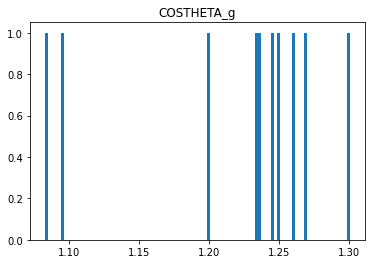

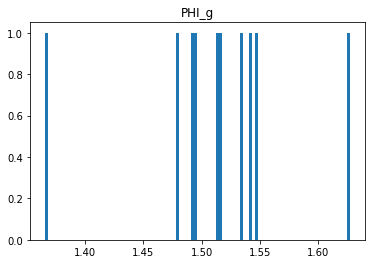

In [34]:
plt.hist(df_fit_results['COSTHETA_g'], bins=100)
plt.title("COSTHETA_g")
plt.show()

plt.hist(df_fit_results['PHI_g'], bins=100)
plt.title("PHI_g")
plt.show()